Epoch 1/200 - Train Loss: 1.2478, Val Loss: 0.8422
Epoch 2/200 - Train Loss: 0.7902, Val Loss: 0.5487
Epoch 3/200 - Train Loss: 0.5299, Val Loss: 0.4563
Epoch 4/200 - Train Loss: 0.4470, Val Loss: 0.4243
Epoch 5/200 - Train Loss: 0.3924, Val Loss: 0.3999
Epoch 6/200 - Train Loss: 0.3573, Val Loss: 0.3700
Epoch 7/200 - Train Loss: 0.3316, Val Loss: 0.3408
Epoch 8/200 - Train Loss: 0.2991, Val Loss: 0.3122
Epoch 9/200 - Train Loss: 0.2812, Val Loss: 0.2867
Epoch 10/200 - Train Loss: 0.2562, Val Loss: 0.2625
Epoch 11/200 - Train Loss: 0.2456, Val Loss: 0.2429
Epoch 12/200 - Train Loss: 0.2186, Val Loss: 0.2247
Epoch 13/200 - Train Loss: 0.2179, Val Loss: 0.2093
Epoch 14/200 - Train Loss: 0.1943, Val Loss: 0.1973
Epoch 15/200 - Train Loss: 0.1866, Val Loss: 0.1871
Epoch 16/200 - Train Loss: 0.1848, Val Loss: 0.1765
Epoch 17/200 - Train Loss: 0.1731, Val Loss: 0.1707
Epoch 18/200 - Train Loss: 0.1655, Val Loss: 0.1629
Epoch 19/200 - Train Loss: 0.1654, Val Loss: 0.1559
Epoch 20/200 - Train 

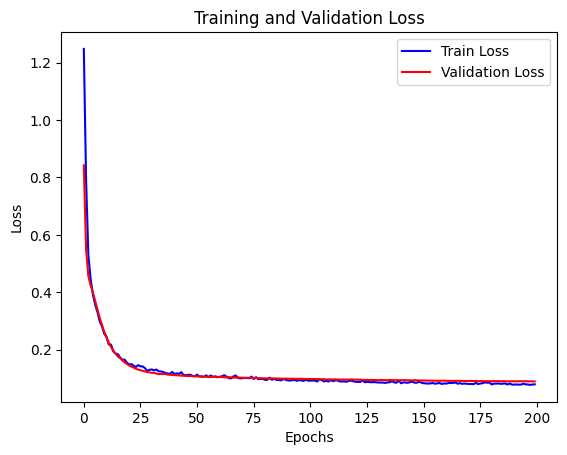


Sample Predictions (MPG):
 True MPG  Predicted MPG
     13.0      14.164163
     31.9      34.735281
     15.0      13.354129
     15.0      14.725256
     29.0      31.325104
     16.5      18.775101
     26.8      24.690027
     26.0      29.855601
     29.0      30.561987
     13.0      13.440112

R² Score: 0.8603
Mean Squared Error: 3.4533


In [11]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mlp import Layer, MultilayerPerceptron, SquaredError, Relu, Linear, Mish, Tanh, Sigmoid, Softmax, Softplus, CrossEntropy
from sklearn.metrics import r2_score

# -------------------- Loading MPG Dataset -------------------- #
class MPGDataLoader:
    """Loads and preprocesses the Auto MPG dataset."""

    def __init__(self, dataset_path):
        """Initialize dataset path."""
        self.dataset_path = dataset_path

    def load_data(self):
        """Load and preprocess the dataset."""
        # Define column names
        columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", 
                   "acceleration", "model year", "origin", "car name"]
        
        # Load dataset with space-separated values and handle missing values
        df = pd.read_csv(self.dataset_path, sep='\s+', names=columns, na_values="?") 
        
        # Drop missing values
        df.dropna(inplace=True)
        
        # Drop 'car name' column since it is non-numeric
        df.drop(columns=["car name"], inplace=True, errors='ignore')
        
        # Convert 'horsepower' column to numeric, handling non-numeric values
        df["horsepower"] = pd.to_numeric(df["horsepower"], errors='coerce')
        
        # Drop any remaining NaN values after conversion
        df.dropna(inplace=True)  
        
        # Separate features (X) and target variable (y)
        y = df["mpg"].values.reshape(-1, 1)
        X = df.drop(columns=["mpg"]).values
        
        return X, y

# Load dataset
dataset_path = 'mpg-data/auto-mpg.data'
dataloader = MPGDataLoader(dataset_path)
X, y = dataloader.load_data()

# -------------------- Splitting Data into Training, Validation, and Test Sets -------------------- #
# 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# -------------------- Normalizing Features Using Training Data Statistics -------------------- #
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fitting scaler on training data and transform all sets
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

# Normalizing target variable (MPG values)
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# -------------------- Defining and Initializing MLP Model -------------------- #
input_dim = X_train.shape[1]  # Number of input features

# Defining MLP architecture with three hidden layers
layers = [
    Layer(input_dim, 64, Relu(), dropout_rate=0.0), # First hidden layer
    Layer(64, 32, Relu(), dropout_rate=0.0),        # Second hidden layer
    Layer(32, 16, Relu(), dropout_rate=0.0),        # Third hidden layer
    Layer(16, 1, Linear())                          # Output layer (regression task)
]

# Instantiating the MLP model
mlp = MultilayerPerceptron(layers)

# -------------------- Training the MLP Model -------------------- #
loss_function = SquaredError()

# Training model using specified hyperparameters
train_losses, val_losses = mlp.train(
    X_train, y_train, X_val, y_val,
    loss_func=loss_function,
    learning_rate=0.001, 
    batch_size=32, 
    epochs=200, 
    optimizer='vanilla', 
    momentum=0.9
)

# -------------------- Plotting Training and Validation Loss -------------------- #
plt.plot(train_losses, label="Train Loss", color = 'b')
plt.plot(val_losses, label="Validation Loss", color = 'r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# -------------------- Evaluating Model Performance -------------------- #
# Generating predictions on test data
y_pred = mlp.forward(X_test, training=False)

# Converting predictions and true values back to original scale
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# -------------------- Display Sample Predictions -------------------- #
# Selecting 10 random samples for comparison
num_samples = 10
indices = np.random.choice(len(y_test), num_samples, replace=False)

# Creating a DataFrame to compare true and predicted MPG values
comparison_df = pd.DataFrame({
    "True MPG": y_test[indices].flatten(),
    "Predicted MPG": y_pred[indices].flatten()
})

# Displaying the table
print("\nSample Predictions (MPG):")
print(comparison_df.to_string(index=False))

# -------------------- Compute Evaluation Metrics -------------------- #
# Computing R² Score (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print(f"\nR² Score: {r2:.4f}")

# Computing Mean Squared Error (MSE)
mse = 0.5*np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse:.4f}")
